In [13]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils
import PIL
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import d2l
from d2l import torch as d2l
from IPython import display
import datetime
import torch.nn.functional as F

In [3]:
#Downloading CIFAR-10
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) #下载太慢请开代理

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


In [14]:
# 引入normalize的数据初始化
tensor_cifar10_normalize_train = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

tensor_cifar10_normalize_val = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

In [15]:
# Build the dataset and DataLoader

label_map = {0: 0, 2: 1} # 占位符
class_names = ['airplane', 'bird']
# 训练集
cifar2 = [(img, label_map[label])
    for img, label in tensor_cifar10_normalize_train
        if label in [0, 2]]
# 验证集
cifar2_val = [(img, label_map[label])
   for img, label in tensor_cifar10_normalize_val
      if label in [0, 2]]

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [16]:
# 使用torch.nn.functional实现更简洁的定义网络的方法
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [17]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [9]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
          imgs = imgs.to(device)
          labels = labels.to(device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [10]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-10-19 08:38:45.263460 Epoch 1, Training loss 0.5780794104193426
2021-10-19 08:38:50.701232 Epoch 10, Training loss 0.3337704032469707
2021-10-19 08:38:56.655401 Epoch 20, Training loss 0.29652411932018913
2021-10-19 08:39:02.711422 Epoch 30, Training loss 0.27169701362111764
2021-10-19 08:39:08.668791 Epoch 40, Training loss 0.2474977240251128
2021-10-19 08:39:14.676253 Epoch 50, Training loss 0.231625190918233
2021-10-19 08:39:20.701209 Epoch 60, Training loss 0.21645306919220905
2021-10-19 08:39:26.785222 Epoch 70, Training loss 0.19962720055678848
2021-10-19 08:39:32.796773 Epoch 80, Training loss 0.18632967347741886
2021-10-19 08:39:38.822620 Epoch 90, Training loss 0.17172261507837636
2021-10-19 08:39:44.833775 Epoch 100, Training loss 0.16385795892613708


In [18]:
class Animator: 
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [22]:
def training_loop_ani(n_epochs, optimizer, model, loss_fn, train_loader):

  animator = Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0.0, 0.6], legend=['train loss'])
  for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

      animator.add(epoch, loss_train / len(train_loader))

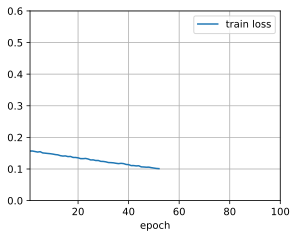

In [ ]:
training_loop_ani(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)